## Detector model: Kiukas / Ruschhaupt / Schmidt / Werner

In [68]:
from sympy import *
#from sympy.physics.matrices import mdft
from sympy.physics.quantum import TensorProduct
from sympy.functions.special.delta_functions import Heaviside
from sympy.physics.quantum.dagger import Dagger

from sympy.stats import ContinuousRV, variance, std

from sympy.plotting import plot, plot3d_parametric_line

import numpy as np

import scipy.integrate

import matplotlib
import matplotlib.pyplot as plt

# matplotlib.rcParams['text.usetex'] = False

# https://matplotlib.org/gallery/mplot3d/lines3d.html?highlight=parametric
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [129]:
from IPython.display import display, Latex #, Math

In [69]:
init_printing ()

In [70]:
gamma = Symbol('gamma', real=True, positive=True)
t = Symbol('t', real=True)
tprime = Symbol('t\'', real=True)
omega = Symbol('omega', real=True)
nu = Symbol('nu', real=True)

In [71]:
H = Matrix ([
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0]
])

In [72]:
H.eigenvects()

⎡⎛      ⎡⎡-1⎤⎤⎞  ⎛        ⎡⎡ 1 ⎤⎤⎞  ⎛       ⎡⎡1 ⎤⎤⎞⎤
⎢⎜      ⎢⎢  ⎥⎥⎟  ⎜        ⎢⎢   ⎥⎥⎟  ⎜       ⎢⎢  ⎥⎥⎟⎥
⎢⎜0, 1, ⎢⎢0 ⎥⎥⎟, ⎜-√2, 1, ⎢⎢-√2⎥⎥⎟, ⎜√2, 1, ⎢⎢√2⎥⎥⎟⎥
⎢⎜      ⎢⎢  ⎥⎥⎟  ⎜        ⎢⎢   ⎥⎥⎟  ⎜       ⎢⎢  ⎥⎥⎟⎥
⎣⎝      ⎣⎣1 ⎦⎦⎠  ⎝        ⎣⎣ 1 ⎦⎦⎠  ⎝       ⎣⎣1 ⎦⎦⎠⎦

In [73]:
U_t = exp(-I*H*t)

In [143]:
psi_0 = Matrix([1, I, 0])/sqrt(2)
psi_0

⎡ √2 ⎤
⎢ ── ⎥
⎢ 2  ⎥
⎢    ⎥
⎢√2⋅ⅈ⎥
⎢────⎥
⎢ 2  ⎥
⎢    ⎥
⎣ 0  ⎦

In [75]:
unitary_psi_t = U_t @ psi_0

In [76]:
unitary_psi_t

⎡     ⎛      √2⋅ⅈ⋅t       -√2⋅ⅈ⋅t⎞      ⎛ √2⋅ⅈ⋅t        -√2⋅ⅈ⋅t⎞⎤
⎢     ⎜  √2⋅ℯ         √2⋅ℯ       ⎟      ⎜ℯ         1   ℯ       ⎟⎥
⎢√2⋅ⅈ⋅⎜- ────────── + ───────────⎟   √2⋅⎜─────── + ─ + ────────⎟⎥
⎢     ⎝      4             4     ⎠      ⎝   4      2      4    ⎠⎥
⎢───────────────────────────────── + ───────────────────────────⎥
⎢                2                                2             ⎥
⎢                                                               ⎥
⎢     ⎛      √2⋅ⅈ⋅t       -√2⋅ⅈ⋅t⎞        ⎛ √2⋅ⅈ⋅t    -√2⋅ⅈ⋅t⎞  ⎥
⎢     ⎜  √2⋅ℯ         √2⋅ℯ       ⎟        ⎜ℯ         ℯ       ⎟  ⎥
⎢  √2⋅⎜- ────────── + ───────────⎟   √2⋅ⅈ⋅⎜─────── + ────────⎟  ⎥
⎢     ⎝      4             4     ⎠        ⎝   2         2    ⎠  ⎥
⎢  ─────────────────────────────── + ─────────────────────────  ⎥
⎢                 2                              2              ⎥
⎢                                                               ⎥
⎢     ⎛      √2⋅ⅈ⋅t       -√2⋅ⅈ⋅t⎞      ⎛ √2⋅ⅈ⋅t        -√2⋅ⅈ⋅t⎞⎥
⎢     ⎜  √

In [138]:
prob_t = Matrix([0, 0, 0])
for i in 0, 1, 2:
    prob_t[i] = abs(unitary_psi_t[i])**2

In [139]:
prob_t

⎡                                                          2  ⎤
⎢  ⎛    √2⋅ⅈ⋅t      √2⋅ⅈ⋅t            -√2⋅ⅈ⋅t      -√2⋅ⅈ⋅t⎞   ⎥
⎢  ⎜√2⋅ℯ         ⅈ⋅ℯ         √2   √2⋅ℯ          ⅈ⋅ℯ       ⎟   ⎥
⎢  ⎜────────── - ───────── + ── + ─────────── + ──────────⎟   ⎥
⎢  ⎝    8            4       4         8            4     ⎠   ⎥
⎢                                                             ⎥
⎢ 2⋅√2⋅ⅈ⋅t         2⋅√2⋅ⅈ⋅t        -2⋅√2⋅ⅈ⋅t         -2⋅√2⋅ⅈ⋅t⎥
⎢ℯ           √2⋅ⅈ⋅ℯ           3   ℯ            √2⋅ⅈ⋅ℯ         ⎥
⎢───────── + ────────────── + ─ + ────────── - ───────────────⎥
⎢    16            8          8       16              8       ⎥
⎢                                                             ⎥
⎢                                                          2  ⎥
⎢  ⎛    √2⋅ⅈ⋅t      √2⋅ⅈ⋅t            -√2⋅ⅈ⋅t      -√2⋅ⅈ⋅t⎞   ⎥
⎢  ⎜√2⋅ℯ         ⅈ⋅ℯ         √2   √2⋅ℯ          ⅈ⋅ℯ       ⎟   ⎥
⎢  ⎜────────── - ───────── - ── + ─────────── + ──────────⎟   ⎥
⎣  ⎝    8            4       4         8

In [140]:
simplify(
    prob_t[0] + prob_t[1] + prob_t[2]
)

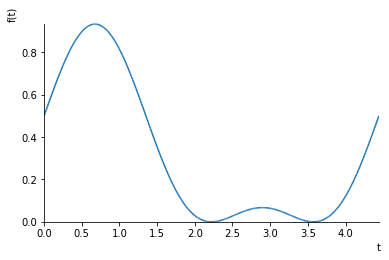

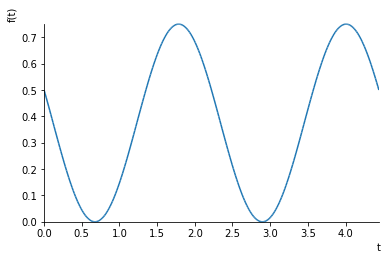

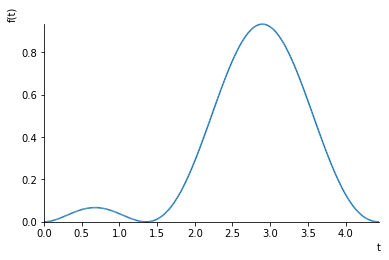

In [144]:
for i in 0, 1, 2:
    plot(prob_t[i], (t, 0, 2*pi/sqrt(2)), adaptive=False)